In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

import seaborn as sns
%matplotlib inline

### Loading data: iris sklearn dataset 

In [2]:
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
target = 'target'
df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


In [3]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

### Auxilliary functions

In [4]:
def is_numeric(val):
    return isinstance(val,int) or isinstance(val,float)
def count_values(rows):
    #more 'universal' value_counts
    if type(rows) == list:
        rows = pd.DataFrame(rows)
    if type(rows)==pd.core.frame.DataFrame:
        counts = pd.value_counts(rows.values[:,-1])
    else:
        counts = rows.value_counts()
    return counts
def str_values(counts):
    if type(counts)==pandas.core.series.Series:
        return 

In [174]:
cnt = count_values(df)

In [178]:
cnt.tolist()

[50, 50]

### Metrics

In [5]:
#gini impurity
def gini(rows):
    counts = count_values(rows)
        
    impurity = 1 
    for count in counts:
        prob = count/float(len(rows))
        impurity -= prob**2
    return impurity

#information gain
def info_gain(left, right, current_uncertainty):
    l,r = len(left), len(right)
    p = l/(l+r)
    weighted_avg = p * gini(left) + (1-p) * gini(right)
    return current_uncertainty - weighted_avg
test = pd.Series([['A'],['B']])
print(gini(test))
gini(df)

0.5


0.6666666666666665

### Binary Decision tree learning: [CART algorithm](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29)

To build a binary decision tree for classification we do the following:

* find best split (choose best gain (a.k.a. choose best question over each row from each feature which maximizes entropy reduction)
* split the data 
* if gain==0, we form a leaf, calculating probability of each class based on num of class representatives
* else, we split data into true_nodes/false_nodes, regarding their answer to a question with best gain
* for each of the nodes we repeat the first step

<img src="MyImage.jpg">

In [6]:
class Question:
    
    def __init__(self, column, value):
        self.column = column
        self.value = value
    
    def match(self, example):
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
        
    def __repr__(self):
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is {0} {1} {2}?".format(df.columns[self.column], condition, str(self.value))

In [7]:
def partition(rows, question):
    """
    Returns:
    -------
    True rows, False rows
    """
    true, false = [],[] 
    for row in rows.values:
        if question.match(row):
            true.append(row)
        else:
            false.append(row)
    return true,false

In [8]:
q = Question(0,5)
true,false = partition(df[:2],q)
print(q)
print(true,false)
df[:2]

Is sepal length (cm) >= 5?
[array([5.1, 3.5, 1.4, 0.2, 0. ])] [array([4.9, 3. , 1.4, 0.2, 0. ])]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0


In [9]:
current_uncertainty = gini(df)
print(current_uncertainty)
t,f = partition(df,q)
info_gain(t,f,current_uncertainty)

0.6666666666666665


0.08546401515151492

In [10]:
def find_best_split(rows):
    best_gain,best_question = 0,None
    
    current_uncertainty = gini(rows)
    n_features = len(rows.columns) - 1
    
    for i in range(n_features):
        values = set(rows[rows.columns[i]].values)
        
        for val in values:
            question = Question(i,val)
            
            true_rows, false_rows = partition(rows,question)
            
            if len(true_rows)==0 or len(false_rows)==0:
                continue
            
            gain = info_gain(true_rows,false_rows,current_uncertainty)
            if gain>=best_gain:
                best_gain,best_question = gain,question
    
    return best_gain, best_question
find_best_split(df)

(0.3333333333333332, Is petal width (cm) >= 1.0?)

In [11]:
class Leaf:
    def __init__(self,rows):
        self.predictions = count_values(rows)
class Decision_Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

def build_tree(rows):
    gain,question = find_best_split(rows)
    
    if gain==0:
        return Leaf(rows)
    
    true_rows, false_rows = partition(rows,question)
    
    true_branch = build_tree(pd.DataFrame(true_rows))
    false_branch = build_tree(pd.DataFrame(false_rows))
    
    return Decision_Node(question,true_branch,false_branch)

def print_tree(node, spacing = ""):
        if isinstance(node, Leaf):
            print (spacing + "Predict", node.predictions)
            return

        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        print_tree(node.true_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        print_tree(node.false_branch, spacing + "  ")

In [12]:
my_tree = build_tree(df)
print_tree(my_tree)

Is petal width (cm) >= 1.0?
--> True:
  Is petal width (cm) >= 1.8?
  --> True:
    Is petal length (cm) >= 4.9?
    --> True:
      Predict 2.0    43
dtype: int64
    --> False:
      Is sepal width (cm) >= 3.2?
      --> True:
        Predict 1.0    1
dtype: int64
      --> False:
        Predict 2.0    2
dtype: int64
  --> False:
    Is petal length (cm) >= 5.0?
    --> True:
      Is petal width (cm) >= 1.6?
      --> True:
        Is petal length (cm) >= 5.8?
        --> True:
          Predict 2.0    1
dtype: int64
        --> False:
          Predict 1.0    2
dtype: int64
      --> False:
        Predict 2.0    3
dtype: int64
    --> False:
      Is petal width (cm) >= 1.7?
      --> True:
        Predict 2.0    1
dtype: int64
      --> False:
        Predict 1.0    47
dtype: int64
--> False:
  Predict 0.0    50
dtype: int64


### Visualization

In [13]:
#classes mapping
dict_c = {0.0:'setosa',
          1.0:'versicolor',
          2.0:'virginica'}
classes = df[df.columns[-1]].replace(dict_c)

In [14]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',max_depth=4)

decision_tree.fit(df[df.columns[:-1]], classes)
export_graphviz(decision_tree, out_file='tree.dot',feature_names = df.columns[:-1].values,
                class_names = classes, filled=True, rounded=True, special_characters=True) 

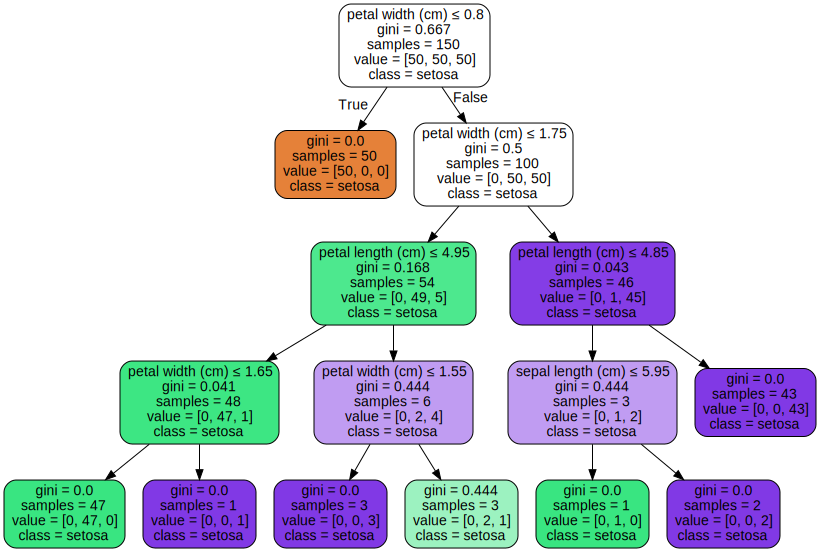

In [15]:
import graphviz
from IPython.display import display
with open("tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### Decision list

A new dataset for binary classification

In [204]:
iris = load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0


In [205]:
#df = df.loc[:99].copy()
df.target.unique()

array([0., 1., 2.])

In [209]:
a = [1,2,3,4]

In [210]:
a.pop()

4

In [227]:
class SequentialCoveringMachine():
    
    def __init__(self,data,min_accuracy = 0.05,iters = 1000):
        
        self.rules_list = []
        
        self.data = data
        self.X = self.data.iloc[:,:-1].copy()
        self.Y = self.data.iloc[:,-1].copy()
    
        self.iters = iters
        self.min_accuracy = min_accuracy
    
    def build_list(self):
        
        rows = self.data.copy()
        gain,question = find_best_split(rows)
        
        while(self.accuracy(rows,predict(rows,question))>self.min_accuracy):
            self.rules_list.append()
            correct_examples = []
            rows = self.remove_correct_examples()
            gain,question = find_best_split(rows)
        
        self.rules_list = sorted(self.rules_list,key=lambda x: x[1])
        
        return self.rules_list
    
    def build_list_draft(self):
        #features,labels = self.X.copy(),self.Y.copy()
        rows = self.data.copy()
        queue,i = [],0
        #initial question, initial gain
        gain,question = find_best_split(rows)
        #while(gain>0):
        while(i<self.iters and queue or i==0):
            true,false = partition(rows,question)

            t,f = pd.DataFrame(true),pd.DataFrame(false)
            
            info = self.strRule(t,question)
            
            self.rules_list.append((info,len(true)))

            rows = queue.pop()
            print('rows',len(rows))
            
            gain,question = find_best_split(rows)
            print(gain)
            i+=1
        #special case with empty nodes - a.k.a. here we should make a leaf
        return (i,sorted(self.rules_list,key=lambda x: x[1]))
    
    
    def accuracy(self,pred):
        if len(pred)!=len(self.labels):
            raise Exception('wrong pred')
        return (pred==self.labels).sum()/len(pred)
    
    def strRule(self,rows,question):
        vals = count_values(rows)#value counts
        cnts = vals.tolist()
        strs = ['class {0} : {1} labels'.format(i,j) for i,j in zip(range(len(l)),l)]
        res = str(question) + "-> " + str(strs)
        return res

In [228]:
s = SequentialCoveringMachine(df)
s.build_list()

100 50
rows 100
0.3896940418679549
46 54
rows 46
0.013547574039067464
43 3
rows 43
0.0
14 29
rows 14
0.0
6 8
rows 6
0.0
3 3
rows 3
0.0
1 2
rows 1
0


AttributeError: 'NoneType' object has no attribute 'match'